In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import tqdm
import sklearn.utils
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from psutil import virtual_memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 17 05:59:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
def load_pubmed_sentences(file_path):
    sentences = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                label, sentence = line.split('\t', 1)
                labels.append(label)
                sentences.append(sentence)
            except ValueError:
                continue
    return sentences, labels


In [ ]:
train_sents, train_labs = load_pubmed_sentences('/content/drive/MyDrive/PubMed/pubmed-rct-master/PubMed_20k_RCT/train.txt')
dev_sents, dev_labs = load_pubmed_sentences('/content/drive/MyDrive/PubMed/pubmed-rct-master/PubMed_20k_RCT/dev.txt')
test_sents, test_labs = load_pubmed_sentences('/content/drive/MyDrive/PubMed/pubmed-rct-master/PubMed_20k_RCT/test.txt')

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labs)

dev_labels_encoded = label_encoder.transform(dev_labs)
test_labels_encoded = label_encoder.transform(test_labs)

df_train = pd.DataFrame({'text': train_sents, 'label': train_labels_encoded})
df_dev = pd.DataFrame({'text': dev_sents, 'label': dev_labels_encoded})
df_test = pd.DataFrame({'text': test_sents, 'label': test_labels_encoded})

In [ ]:
print("Classes:", label_encoder.classes_)
print("Train size:", len(df_train))
print("Validation size:", len(df_dev))
print("Test size:", len(df_test))


Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']
Train size: 180040
Validation size: 30212
Test size: 30135


Labels  [0 1 2 3 4]
Label counts  [21727 27168 59353 13839 57953]


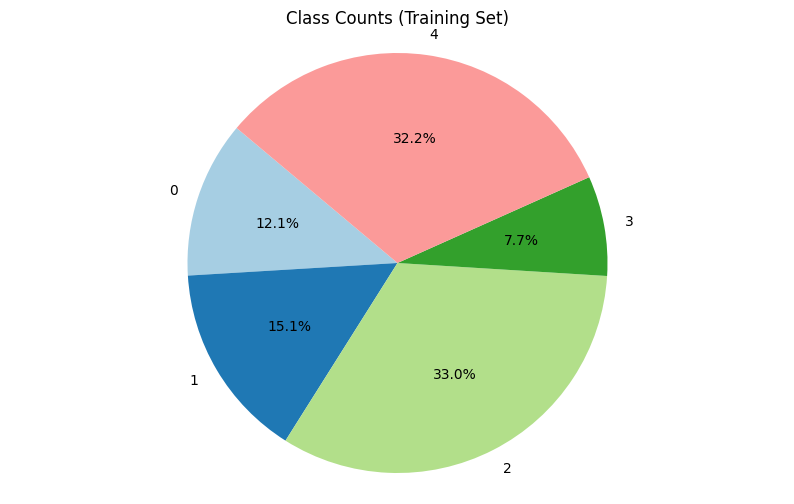

The label 0 has 21727 records in the training dataset.
The label 1 has 27168 records in the training dataset.
The label 2 has 59353 records in the training dataset.
The label 3 has 13839 records in the training dataset.
The label 4 has 57953 records in the training dataset.


In [ ]:
lbls = df_train['label'].values

labels = np.unique(lbls)
labelCounts = np.unique(lbls, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

plt.figure(figsize=(10, 6))
plt.title("Class Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the training dataset.")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
def encode_dataset(df, tokenizer, max_length=128):
    inputs = tokenizer(
        df['text'].tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    labels = torch.tensor(df['label'].values)
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [ ]:
train_dataset = encode_dataset(df_train, tokenizer)
val_dataset = encode_dataset(df_dev, tokenizer)
test_dataset = encode_dataset(df_test, tokenizer)

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)


In [ ]:
def train_model(model, train_loader, val_loader, save_path, epochs=20,
                learning_rates=[2e-5, 5e-6, 1e-6, 2e-6], patience=7):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_f1 = 0

    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")
        optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        patience_counter = 0

        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, labels = batch

                model.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                total_loss += loss.item()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch + 1} Train Loss: {avg_train_loss:.4f}")

            # ----- Validation -----
            model.eval()
            preds, true = [], []
            with torch.no_grad():
                for batch in val_loader:
                    batch = tuple(t.to(device) for t in batch)
                    input_ids, input_mask, labels = batch
                    outputs = model(input_ids=input_ids, attention_mask=input_mask)
                    logits = outputs.logits
                    batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
                    preds.extend(batch_preds)
                    true.extend(labels.cpu().numpy())

            f1 = f1_score(true, preds, average='micro')
            print(f"Epoch {epoch + 1}, Validation Micro F1: {f1:.4f}")

            if f1 > best_val_f1:
                best_val_f1 = f1
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
                print("Best model saved.")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.2",
    num_labels=len(label_encoder.classes_)
)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    save_path="/content/drive/MyDrive/PubMed/best_biobert_pubmed.pt",
    epochs=20,
    learning_rates=[2e-5, 5e-6, 1e-6, 2e-6],
    patience=7
)


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with learning rate: 2e-05


Epoch 1/20:   0%|          | 0/5627 [00:00<?, ?batch/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 5627/5627 [14:17<00:00,  6.57batch/s]


Epoch 1 Train Loss: 0.5459
Epoch 1, Validation Micro F1: 0.8757
Best model saved.


Epoch 2/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.57batch/s]


Epoch 2 Train Loss: 0.3511
Epoch 2, Validation Micro F1: 0.8761
Best model saved.


Epoch 3/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.58batch/s]


Epoch 3 Train Loss: 0.3082
Epoch 3, Validation Micro F1: 0.8713
No improvement. Patience: 1/7


Epoch 4/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.58batch/s]


Epoch 4 Train Loss: 0.2502
Epoch 4, Validation Micro F1: 0.8763
Best model saved.


Epoch 5/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.58batch/s]


Epoch 5 Train Loss: 0.2010
Epoch 5, Validation Micro F1: 0.8750
No improvement. Patience: 1/7


Epoch 6/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.58batch/s]


Epoch 6 Train Loss: 0.1564
Epoch 6, Validation Micro F1: 0.8720
No improvement. Patience: 2/7


Epoch 7/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.57batch/s]


Epoch 7 Train Loss: 0.1204
Epoch 7, Validation Micro F1: 0.8661
No improvement. Patience: 3/7


Epoch 8/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 8 Train Loss: 0.0948
Epoch 8, Validation Micro F1: 0.8633
No improvement. Patience: 4/7


Epoch 9/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 9 Train Loss: 0.0734
Epoch 9, Validation Micro F1: 0.8695
No improvement. Patience: 5/7


Epoch 10/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.57batch/s]


Epoch 10 Train Loss: 0.0574
Epoch 10, Validation Micro F1: 0.8658
No improvement. Patience: 6/7


Epoch 11/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.57batch/s]


Epoch 11 Train Loss: 0.0475
Epoch 11, Validation Micro F1: 0.8657
No improvement. Patience: 7/7
Early stopping triggered.

Training with learning rate: 5e-06


Epoch 1/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 1 Train Loss: 0.0238
Epoch 1, Validation Micro F1: 0.8692
No improvement. Patience: 1/7


Epoch 2/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.57batch/s]


Epoch 2 Train Loss: 0.0195
Epoch 2, Validation Micro F1: 0.8701
No improvement. Patience: 2/7


Epoch 3/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 3 Train Loss: 0.0185
Epoch 3, Validation Micro F1: 0.8690
No improvement. Patience: 3/7


Epoch 4/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.57batch/s]


Epoch 4 Train Loss: 0.0158
Epoch 4, Validation Micro F1: 0.8677
No improvement. Patience: 4/7


Epoch 5/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 5 Train Loss: 0.0140
Epoch 5, Validation Micro F1: 0.8711
No improvement. Patience: 5/7


Epoch 6/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 6 Train Loss: 0.0122
Epoch 6, Validation Micro F1: 0.8690
No improvement. Patience: 6/7


Epoch 7/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 7 Train Loss: 0.0117
Epoch 7, Validation Micro F1: 0.8708
No improvement. Patience: 7/7
Early stopping triggered.

Training with learning rate: 1e-06


Epoch 1/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.58batch/s]


Epoch 1 Train Loss: 0.0067
Epoch 1, Validation Micro F1: 0.8694
No improvement. Patience: 1/7


Epoch 2/20: 100%|██████████| 5627/5627 [14:14<00:00,  6.58batch/s]


Epoch 2 Train Loss: 0.0057
Epoch 2, Validation Micro F1: 0.8677
No improvement. Patience: 2/7


Epoch 3/20: 100%|██████████| 5627/5627 [14:14<00:00,  6.58batch/s]


Epoch 3 Train Loss: 0.0049
Epoch 3, Validation Micro F1: 0.8700
No improvement. Patience: 3/7


Epoch 4/20: 100%|██████████| 5627/5627 [14:13<00:00,  6.59batch/s]


Epoch 4 Train Loss: 0.0045
Epoch 4, Validation Micro F1: 0.8711
No improvement. Patience: 4/7


Epoch 5/20: 100%|██████████| 5627/5627 [14:12<00:00,  6.60batch/s]


Epoch 5 Train Loss: 0.0046
Epoch 5, Validation Micro F1: 0.8702
No improvement. Patience: 5/7


Epoch 6/20: 100%|██████████| 5627/5627 [14:12<00:00,  6.60batch/s]


Epoch 6 Train Loss: 0.0037
Epoch 6, Validation Micro F1: 0.8705
No improvement. Patience: 6/7


Epoch 7/20: 100%|██████████| 5627/5627 [14:12<00:00,  6.60batch/s]


Epoch 7 Train Loss: 0.0029
Epoch 7, Validation Micro F1: 0.8702
No improvement. Patience: 7/7
Early stopping triggered.

Training with learning rate: 2e-06


Epoch 1/20: 100%|██████████| 5627/5627 [14:14<00:00,  6.59batch/s]


Epoch 1 Train Loss: 0.0035
Epoch 1, Validation Micro F1: 0.8703
No improvement. Patience: 1/7


Epoch 2/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 2 Train Loss: 0.0043
Epoch 2, Validation Micro F1: 0.8689
No improvement. Patience: 2/7


Epoch 3/20: 100%|██████████| 5627/5627 [14:16<00:00,  6.57batch/s]


Epoch 3 Train Loss: 0.0047
Epoch 3, Validation Micro F1: 0.8714
No improvement. Patience: 3/7


Epoch 4/20: 100%|██████████| 5627/5627 [14:14<00:00,  6.58batch/s]


Epoch 4 Train Loss: 0.0038
Epoch 4, Validation Micro F1: 0.8708
No improvement. Patience: 4/7


Epoch 5/20: 100%|██████████| 5627/5627 [14:14<00:00,  6.58batch/s]


Epoch 5 Train Loss: 0.0047
Epoch 5, Validation Micro F1: 0.8704
No improvement. Patience: 5/7


Epoch 6/20: 100%|██████████| 5627/5627 [14:15<00:00,  6.58batch/s]


Epoch 6 Train Loss: 0.0039
Epoch 6, Validation Micro F1: 0.8711
No improvement. Patience: 6/7


Epoch 7/20: 100%|██████████| 5627/5627 [14:14<00:00,  6.58batch/s]


Epoch 7 Train Loss: 0.0034
Epoch 7, Validation Micro F1: 0.8705
No improvement. Patience: 7/7
Early stopping triggered.


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/PubMed/best_biobert_pubmed.pt"))
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

test_preds = []
test_true = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_preds_labels = label_encoder.inverse_transform(test_preds)
test_true_labels = label_encoder.inverse_transform(test_true)

print("\nClassification Report on Test Set:")
print(classification_report(test_true_labels, test_preds_labels))

Evaluating on Test Set: 100%|██████████| 942/942 [00:44<00:00, 21.19it/s]



Classification Report on Test Set:
              precision    recall  f1-score   support

  BACKGROUND       0.71      0.74      0.73      3621
 CONCLUSIONS       0.86      0.81      0.83      4571
     METHODS       0.93      0.94      0.93      9897
   OBJECTIVE       0.71      0.64      0.67      2333
     RESULTS       0.91      0.93      0.92      9713

    accuracy                           0.87     30135
   macro avg       0.82      0.81      0.82     30135
weighted avg       0.87      0.87      0.87     30135

